In [49]:
import pandas as pd
import networkx as nx
import numpy as np

In [50]:
author_df = pd.read_csv('data/exrx_author_final.csv')
report_df = pd.read_csv('data/article_list.csv')

In [51]:
# filter author_df
author_df = author_df[author_df['report_id'].isin(report_df['Our ID'].to_list())]

In [52]:
# extract the ids of systematic review report (SRR)
srr_id_list = report_df.loc[report_df['Our Item Type'] == "ReviewArticle"]['Our ID'].to_list()

In [53]:
# extract the ids of primary study reports (PSRs)
psr_id_list = report_df.loc[report_df['Our Item Type'] == "includedItem"]['Our ID'].to_list()

In [54]:
# create an author dictionary
author_df['author_full_name'] = author_df['author_given_name'] + ' ' + author_df['author_surname']
author_info = author_df[['author_id', 'author_full_name']].groupby('author_id').aggregate('max')
author_id = author_info.index.to_list()
author_name = author_info['author_full_name'].to_list()
author_dict = {author_id[i]:author_name[i] for i in range(len(author_id))}

In [55]:
# adding to author_info dataframe with the number of SRRs and PSRs authored, and compute the percentage of SRRs
author_info = author_df[['author_id', 'report_id']].groupby('author_id')['report_id'].apply(list)
author_info = pd.DataFrame(author_info)
author_info['no_of_srrs'] = author_info['report_id'].apply(lambda x: sum([y in srr_id_list for y in x]))
author_info['no_of_psrs'] = author_info['report_id'].apply(lambda x: sum([y in psr_id_list for y in x]))
author_info['percent_srrs'] = author_info['no_of_srrs'] / (author_info['no_of_srrs'] + author_info['no_of_psrs'])
author_info['author_full_name'] = [author_dict[idx] for idx in author_info.index]
author_info['author_full_name'] = [author_dict[idx] for idx in author_info.index]

In [56]:
report_id = report_df['Our ID'].to_list()

In [57]:
# edge_list
report_node_set = author_df['report_id'].to_list()
author_node_set = author_df['author_id'].to_list()
edge_list = [(report_node_set[i], author_node_set[i]) for i in range(len(report_node_set))]

In [58]:
# create two co-author matrix, one for SRRs and one for PSRs

# create blank a matrix (author(row names) * report (column names))
srr_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                 columns=report_id,
                 index=author_id)

psr_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                      columns=report_id,
                      index=author_id)


# create the author * report matrix
for i in range(len(edge_list)):
    if edge_list[i][0] in srr_id_list:
        row_index = edge_list[i][1]
        column_index = edge_list[i][0]
        srr_df[column_index][row_index] = 1
    elif edge_list[i][0] in psr_id_list:
        row_index = edge_list[i][1]
        column_index = edge_list[i][0]
        psr_df[column_index][row_index] = 1

# using matrix algebra to create the co-author network, weight is the nature of collaboration (100% review to 0% review)
srr_coauthor_adj_mat = np.matrix(srr_df)*np.matrix(srr_df).transpose()
psr_coauthor_adj_mat = np.matrix(psr_df)*np.matrix(psr_df).transpose()

# create two edgelists
srr_coauthor_adj_mat = pd.DataFrame(srr_coauthor_adj_mat, columns=author_id, index=author_id)
psr_coauthor_adj_mat = pd.DataFrame(psr_coauthor_adj_mat, columns=author_id, index=author_id)
srr_edgelist_df = pd.DataFrame(srr_coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_srrs_coauthored'})
psr_edgelist_df = pd.DataFrame(psr_coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_psrs_coauthored'})

In [31]:
srr_edgelist_df[srr_edgelist_df['no_of_srrs_coauthored'] != 0]

,source,target,no_of_srrs_coauthored
305136,163,163,1.0
305137,163,164,1.0
305138,163,165,1.0
305161,163,190,1.0
307091,164,163,1.0
...,...,...,...
3821060,57327765900,14016488400,1.0
3821158,57327765900,21734345600,1.0
3821721,57327765900,56218826200,1.0
3821968,57327765900,57205168661,1.0


In [59]:
# create a matrix (author(row names) * report (column names))
author_report_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                 columns=report_id,
                 index=author_id)

for i in range(len(edge_list)):
    row_index = edge_list[i][1]
    column_index = edge_list[i][0]
    author_report_df[column_index][row_index] = 1

# using matrix algebra to create the co-author network
coauthor_mat = np.matrix(author_report_df)*np.matrix(author_report_df).transpose()

# create a new df to hold the adjacency matrix
coauthor_adj_mat = pd.DataFrame(coauthor_mat, columns=author_id, index=author_id)
total_edgelist_df = pd.DataFrame(coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_reports_coauthored'})

In [60]:
srr_edgelist_df.head(5)

,source,target,no_of_srrs_coauthored
0,1,1,0.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


In [61]:
psr_edgelist_df.head(5)

,source,target,no_of_psrs_coauthored
0,1,1,1.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


In [62]:
total_edgelist_df.head(5)

,source,target,no_of_reports_coauthored
0,1,1,1.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


In [63]:
# merge the three dataframes
edgelist_df = total_edgelist_df.merge(right=srr_edgelist_df, on=['source', 'target']).merge(right=psr_edgelist_df, on=['source', 'target'])
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored
0,1,1,1.0,0.0,1.0
1,1,2,0.0,0.0,0.0
2,1,3,0.0,0.0,0.0
3,1,4,0.0,0.0,0.0
4,1,5,0.0,0.0,0.0


In [64]:
# trim off the entries where no_of_reports_coauthored == 0
edgelist_df = edgelist_df[edgelist_df['no_of_reports_coauthored'] != 0]
edgelist_df.shape

(15992, 5)

In [65]:
# trim off self loop (source == target)
edgelist_df = edgelist_df[edgelist_df['source'] != edgelist_df['target']]
edgelist_df.shape

(14096, 5)

In [66]:
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored
1898,2,3,1.0,0.0,1.0
1899,2,4,1.0,0.0,1.0
1900,2,5,1.0,0.0,1.0
3793,3,2,1.0,0.0,1.0
3795,3,4,1.0,0.0,1.0


In [67]:
# compute percentage
edgelist_df['percent_srrs'] = edgelist_df['no_of_srrs_coauthored']/edgelist_df['no_of_reports_coauthored']
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored,percent_srrs
1898,2,3,1.0,0.0,1.0,0.0
1899,2,4,1.0,0.0,1.0,0.0
1900,2,5,1.0,0.0,1.0,0.0
3793,3,2,1.0,0.0,1.0,0.0
3795,3,4,1.0,0.0,1.0,0.0


<AxesSubplot:>

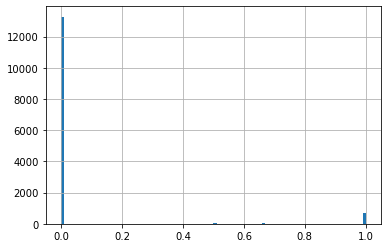

In [68]:
# visualize histogram of the percent_srrs among edges
edgelist_df['percent_srrs'].hist(bins=100)

<AxesSubplot:>

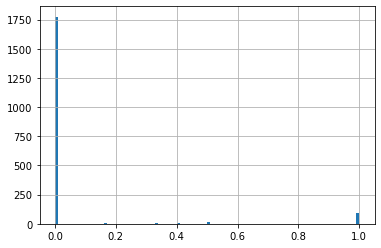

In [69]:
# visualize histogram of the percent_srr among articles
author_info['percent_srrs'].hist(bins=100)

In [70]:
# pacakge data for visualization
edgelist_df.to_csv("ExRx_coauthor_network_edgelist.csv", index=False)
author_info.to_csv("ExRx_coauthor_network_attribute_list.csv", index=True)